In [1]:
# Import packages
import pprint 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# EDA for WiDS Datathon 2024 - Challenge 1

"Utilizing a unique oncology dataset, you will develop a model to predict if patients received metastatic cancer diagnosis within 90 days of screening."

"Gilead Sciences is the sponsor for this year’s WiDS Datathon. They provided a rich, real-world dataset which contains information about demographics, diagnosis and treatment options, and insurance provided about patients who were diagnosed with breast cancer from 2015-2018. The dataset originated from Health Verity, one of the largest healthcare data ecosystems in the US. It was enriched with third party geo-demographic data to provide views into the socio economic aspects that may contribute to health equity. For this challenge, the dataset was then further enriched with zip code level toxicology data NASA/Columbia University.

*Challenge task:*

You will be asked to predict if the patients received metastatic cancer diagnosis within 90 days of screening.

*Why is this important?*

Metastatic TNBC is considered the most aggressive TNBC and requires most urgent and timely treatment. Unnecessary delays in diagnosis and subsequent treatment can have devastating effects in these difficult cancers. Differences in the wait time to get treatment is a good proxy for disparities in healthcare access.

The primary goal of building these models is to detect relationships between demographics of the patient with the likelihood of getting timely treatment. The secondary goal is to see if environmental hazards impact proper diagnosis and treatment."

In [2]:
data = pd.read_csv('./data/training.csv')

## Initial Data Notes

First, we examined the 83 variables. Less than half are data specific to the individual; the rest of the data is zip code or proxy demographic data to indicate other demographic information.

We noted that patients can be identified using the patient_id and the outcome variable is DiagPeriodL90D. The outcome variable is currently binary, where 1 = yes, diagnosis returned within 90 days of screening, and 0 = no, more than 90 days for diagnosis.

In [3]:
data.shape

(12906, 83)

In [4]:
data.columns

Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'in

Next, we checked whether data was missing.

We found metastatic treatment treatment variables (99.8%), BMI (69.46%), and race (49.47%) are missing for many patients.

In [5]:
print('top NA by percent')
data.isna().sum().sort_values(ascending = False)/len(data)

top NA by percent


metastatic_first_novel_treatment         0.998140
metastatic_first_novel_treatment_type    0.998140
bmi                                      0.694638
patient_race                             0.494731
payer_type                               0.139702
                                           ...   
breast_cancer_diagnosis_code             0.000000
patient_gender                           0.000000
patient_age                              0.000000
patient_zip3                             0.000000
DiagPeriodL90D                           0.000000
Length: 83, dtype: float64

Given the amount of missingness, but also given how possibly important patient race and payer type can be, we decided to fill in the NA with an "Unknown" category for now. It may be difficult to accurately fill in or infer patient race or payer type with the given information.

In [6]:
data['patient_race'] = data['patient_race'].fillna('Unknown')
data['payer_type'] = data['payer_type'].fillna('Unknown')

We also checked the datatypes, just in case there are unexpected datatypes (there aren't).

In [7]:
# Examine the datatypes
data.dtypes

patient_id          int64
patient_race       object
payer_type         object
patient_state      object
patient_zip3        int64
                   ...   
veteran           float64
Ozone             float64
PM25              float64
N02               float64
DiagPeriodL90D      int64
Length: 83, dtype: object

We examined the outcome variable to see how balanced the dataset is. We found the data is roughly 62% received timely diagnosis, 38% untimely, so not completely balanced but likely not unbalanced enough to affect performance.

In [8]:
print('Outcome in Counts')
print(data['DiagPeriodL90D'].value_counts())
print()
print('Outcome in Percent')
print(data['DiagPeriodL90D'].value_counts() / len(data))

Outcome in Counts
1    8060
0    4846
Name: DiagPeriodL90D, dtype: int64

Outcome in Percent
1    0.624516
0    0.375484
Name: DiagPeriodL90D, dtype: float64


We decided to drop the drop the variables with too many NAs that can't be filled or aren't useful. Given that metastatic treatment variables are almost 100% empty, BMI cannot be filled or guessed at all with available info, and the patient gender is almost 100% female, we dropped these columns.

In [9]:
data = data.drop(columns = ['metastatic_first_novel_treatment', 
           'metastatic_first_novel_treatment_type',
           'bmi',
           'patient_gender'])

In [10]:
data

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,Unknown,MEDICAID,CA,924,84,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,C50112,Malignant neoplasm of central portion of left ...,C773,South,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,Unknown,COMMERCIAL,ID,836,55,1749,"Malignant neoplasm of breast (female), unspeci...",C773,West,...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,674178,White,Unknown,OH,436,50,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,Midwest,...,17.400000,23.600000,0.864706,19.841176,6.300000,6.247059,38.753055,8.068682,21.140731,1
12902,452909,Unknown,COMMERCIAL,CA,945,50,C50912,Malignant neoplasm of unspecified site of left...,C773,West,...,11.243210,7.837037,5.411250,34.700000,3.845679,5.671605,36.469947,6.265266,10.728732,1
12903,357486,Unknown,COMMERCIAL,CA,926,61,C50912,Malignant neoplasm of unspecified site of left...,C7931,West,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,1
12904,935417,Unknown,Unknown,NY,112,37,1749,"Malignant neoplasm of breast (female), unspeci...",C773,Northeast,...,10.194737,18.642105,14.173684,42.502632,6.392105,1.755263,37.722740,7.879795,27.496367,0


## Numeric variables

We examined the numeric variables in more detail. We ignored patient ID and zip code, as these are not truly numeric variables.

The ranges were as expected for the numeric variables. Percents for the population percent in a zip code related variables, such as age_median, are not at the decimal scale (< 1) but instead at the 0 - 100 scale.

In [11]:
data.describe()

,patient_id,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
count,12906.000000,12906.000000,12906.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,12905.000000,...,12905.000000,12902.000000,12902.000000,12905.000000,12905.000000,12905.000000,12877.000000,12877.000000,12877.000000,12906.000000
mean,547381.196033,573.754300,59.183326,20744.441237,1581.950419,40.502259,11.122784,12.945265,13.290376,12.862036,...,13.335299,13.406950,4.474956,27.978387,8.575284,7.083376,39.822352,7.475221,16.098988,0.624516
std,260404.959974,275.447534,13.335216,13886.903756,2966.305306,4.036963,1.512376,1.923974,3.354103,2.324922,...,3.690949,5.222495,4.837085,5.083939,4.203482,3.109022,3.559492,1.516499,5.842501,0.484266
min,100063.000000,101.000000,18.000000,635.545455,0.916667,20.600000,0.000000,6.314286,5.925000,1.500000,...,4.600000,3.433333,0.000000,12.460784,2.440000,1.200000,30.939316,2.636008,2.760371,0.000000
25%,321517.000000,331.000000,50.000000,9463.896552,171.857143,37.129825,10.160000,11.741176,11.013415,11.292105,...,10.270492,9.663333,0.994444,24.933333,5.618750,4.929688,37.698880,6.651215,11.280694,0.000000
50%,543522.000000,554.000000,59.000000,19154.190480,700.337500,40.639344,11.039216,12.923944,12.538095,12.442647,...,12.884000,12.177778,2.747222,27.788235,7.465714,6.847059,39.108249,7.686577,15.589148,1.000000
75%,772671.750000,846.000000,67.000000,30021.278690,1666.515385,42.934783,12.190000,14.019767,14.971053,14.026667,...,15.555405,16.635556,5.976000,30.709375,10.617442,8.620000,41.136513,8.276922,20.801880,1.000000
max,999896.000000,999.000000,91.000000,71374.131580,21172.000000,54.570000,17.675000,35.300000,62.100000,25.471429,...,35.155556,38.347826,26.755000,48.020000,27.566102,25.200000,52.237210,11.169408,31.504775,1.000000


Comparing the means of the numeric variables, there are not huge differences. Patient age is different by roughly one year, while the average population of the zip code for a timely or untimely diagnosis patient is different by about 200 and density differed.

The difference in patient age, average zip code population, and zip code density was apparent and varied slightly across races and payer types.

In [12]:
# Compare the numeric variable means between the timely and untimely diagnosis groups
data.groupby(by = ['DiagPeriodL90D']).mean(numeric_only = True)

,patient_id,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,...,hispanic,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02
DiagPeriodL90D,,,,,,,,,,,,,,,,,,,,,
0,546573.420347,560.834090,58.226579,20862.216678,1648.084687,40.504365,11.140313,12.982914,13.275525,12.804439,...,18.568836,13.432298,13.574132,4.546356,28.157887,8.730147,7.087510,39.786166,7.507490,16.093241
1,547866.863648,581.522457,59.758561,20673.644462,1542.196010,40.500993,11.112247,12.922633,13.299303,12.896658,...,18.393006,13.276992,13.306484,4.432049,27.870487,8.482193,7.080891,39.844108,7.455821,16.102443


In [13]:
# Compare the numeric variable means between the timely and untimely diagnosis groups within racial groups
data.groupby(by = ['patient_race','DiagPeriodL90D']).mean(numeric_only = True)

patient_id  patient_zip3  patient_age  \
patient_race DiagPeriodL90D                                             
Asian        0               576156.437037    723.481481    55.444444   
             1               578611.260870    716.847826    60.113043   
Black        0               546124.262255    454.941176    57.762255   
             1               550026.527778    465.074074    58.871914   
Hispanic     0               575797.249180    738.200000    55.144262   
             1               531117.387405    760.143130    55.416031   
Other        0               525091.658824    575.858824    56.180392   
             1               551578.221963    594.193925    57.761682   
Unknown      0               542650.548016    548.951984    57.834921   
             1               549312.598965    575.871410    59.214748   
White        0               548731.857727    555.324612    60.690924   
             1               544961.926427    567.634249    62.179281   

                               population      density  age_median  \
patient_race DiagPeriodL90D                                          
Asian        0               32429.766831  3080.545284   39.280839   
             1               31085.086087  2943.980682   39.454603   
Black        0               24444.086343  2388.106032   38.701880   
             1               24288.510799  2441.396229   38.650483   
Hispanic     0               29493.315003  2180.467260   39.014765   
             1               27786.687891  2055.855916   39.173563   
Other        0               21173.733859  1672.542806   40.786856   
             1               22230.465810  1568.709753   41.001548   
Unknown      0               19883.461911  1640.106886   40.598313   
             1               19895.510363  1487.643329   40.524690   
White        0               18192.633617  1122.262682   41.358273   
             1               18084.582745  1130.038812   41.274585   

                             age_under_10  age_10_to_19    age_20s    age_30s  \
patient_race DiagPeriodL90D                                                     
Asian        0                  11.048348     12.793967  14.536193  13.735553   
             1                  11.163540     12.757427  13.927453  13.806895   
Black        0                  11.192350     12.986971  14.881578  13.835638   
             1                  11.271428     12.884499  14.949106  13.853984   
Hispanic     0                  11.529094     13.148729  14.049854  13.405993   
             1                  11.318657     13.043110  14.164595  13.512153   
Other        0                  10.937087     12.844360  13.279576  12.802871   
             1                  10.753360     12.830665  13.222945  12.831912   
Unknown      0                  11.214581     13.100696  13.066890  12.663215   
             1                  11.231866     13.057787  13.106317  12.776161   
White        0                  10.925535     12.747267  12.837832  12.499789   
             1                  10.887373     12.718222  12.923665  12.618100   

                             ...   hispanic   disabled    poverty  \
patient_race DiagPeriodL90D  ...                                    
Asian        0               ...  28.668041  11.099525  12.200117   
             1               ...  28.538350  11.382642  12.653698   
Black        0               ...  15.992657  13.703514  16.833013   
             1               ...  16.802224  13.701635  16.835445   
Hispanic     0               ...  40.598131  12.164268  14.750131   
             1               ...  38.013688  12.159117  14.272902   
Other        0               ...  21.059008  13.233999  13.284005   
             1               ...  21.400069  12.989018  13.087346   
Unknown      0               ...  17.044031  13.471946  13.173761   
             1               ...  16.991707  13.208492  12.888186   
White        0               ...  15.440211  13.875424  13.232811

In [14]:
# Compare the numeric variable means between the timely and untimely diagnosis groups within payer types
data.groupby(by = ['payer_type','DiagPeriodL90D']).mean(numeric_only = True)

patient_id  patient_zip3  patient_age  \
payer_type         DiagPeriodL90D                                             
COMMERCIAL         0               548763.658678    582.406198    54.869008   
                   1               551275.685493    601.219823    55.890642   
MEDICAID           0               540123.185814    543.739261    54.942058   
                   1               534557.052934    573.972577    55.885842   
MEDICARE ADVANTAGE 0               551868.595531    513.668156    72.440223   
                   1               555511.675793    528.025513    74.098942   
Unknown            0               539813.281132    574.269811    55.758491   
                   1               544938.274156    602.465829    57.400628   

                                     population      density  age_median  \
payer_type         DiagPeriodL90D                                          
COMMERCIAL         0               18999.541592  1250.878018   40.629367   
                   1               19313.099539  1186.786095   40.617538   
MEDICAID           0               24282.372665  2270.769574   40.018247   
                   1               23213.143199  2014.014534   40.228128   
MEDICARE ADVANTAGE 0               21846.163500  2019.349970   40.788255   
                   1               20922.555164  1858.871689   40.584109   
Unknown            0               21252.566328  1659.920205   40.371406   
                   1               21091.833578  1569.714748   40.401480   

                                   age_under_10  age_10_to_19    age_20s  \
payer_type         DiagPeriodL90D                                          
COMMERCIAL         0                  11.226365     13.121391  12.999279   
                   1                  11.166479     13.088332  13.048656   
MEDICAID           0                  11.183941     12.857629  13.704372   
                   1                  11.049002     12.769908  13.716999   
MEDICARE ADVANTAGE 0                  10.918925     12.824445  13.386819   
                   1                  11.111280     12.812030  13.296794   
Unknown            0                  11.038937     12.854614  13.539786   
                   1                  11.037495     12.780217  13.499164   

                                     age_30s  ...   hispanic   disabled  \
payer_type         DiagPeriodL90D             ...                         
COMMERCIAL         0               12.635191  ...  17.276541  13.407127   
                   1               12.725970  ...  17.567524  13.191784   
MEDICAID           0               13.167185  ...  21.709684  13.469650   
                   1               13.177647  ...  21.625195  13.522048   
MEDICARE ADVANTAGE 0               12.762075  ...  17.410968  13.428244   
                   1               12.865089  ...  15.921025  13.411695   
Unknown            0               12.964349  ...  20.498643  13.483603   
                   1               13.074714  ...  19.874577  13.046871   

                                     poverty  limited_english  commute_time  \
payer_type         DiagPeriodL90D                                             
COMMERCIAL         0               12.896278         3.974052     27.747237   
                   1               12.713351         3.975504     27.662658   
MEDICAID           0               14.790477         5.543322     29.244393   
                   1               14.594450         5.508578     28.623249   
MEDICARE ADVANTAGE 0               13.810304         4.725898     28.021235   
                   1               13.578916         4.253176     27.683986   
Unknown            0               13.972872         4.973108     28.213677   
                   1               13.060101         4.628092     27.768407   

                                   health_uninsured   veteran      Ozone  \
payer_type         DiagPeriodL90D                                          
COMMERCIAL         0           

We examined the difference in distributions between numeric variables in more detail by looking at the KDE graphs.

Looking at the scale of the KDE graphs, the differences were almost minute (less than 1% difference) in densities between the untimely and timely diagnosis groups for almost every variable.

In [15]:
# Collect the numeric variables
num_cols = [col for col in data if data[col].dtype != "object"]

num_cols.remove('patient_id')
num_cols.remove('patient_zip3')

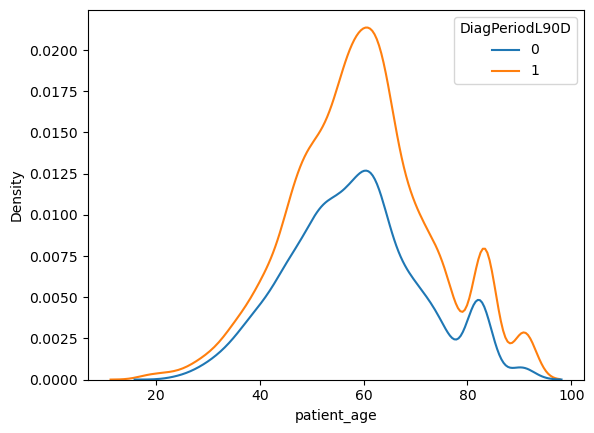

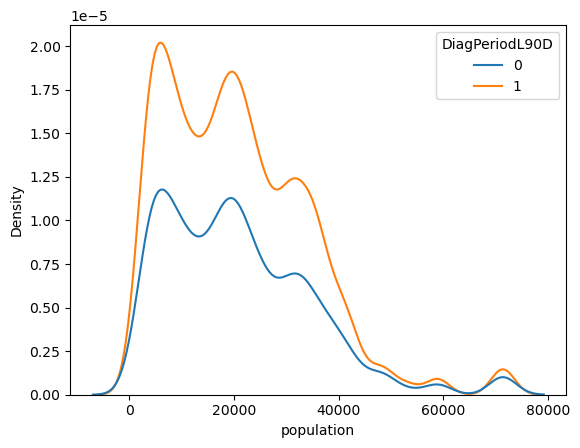

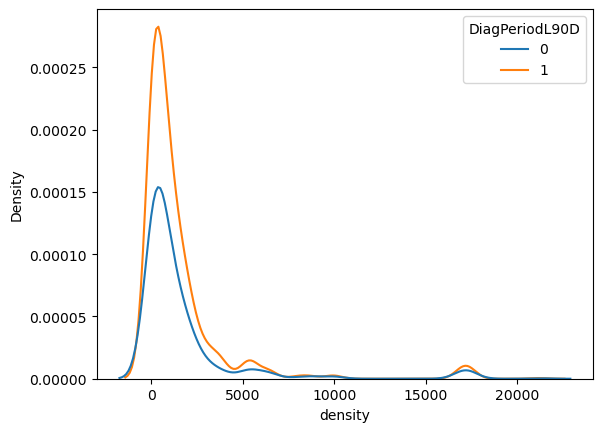

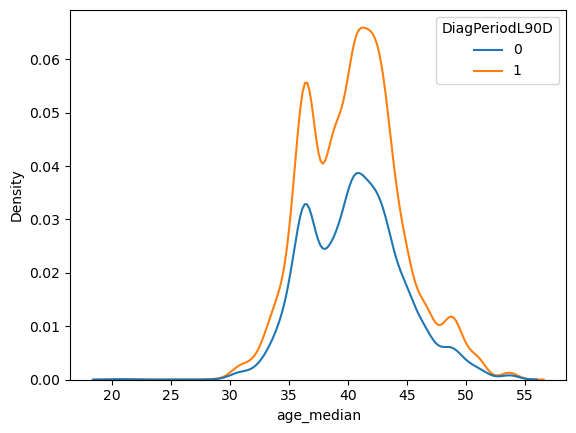

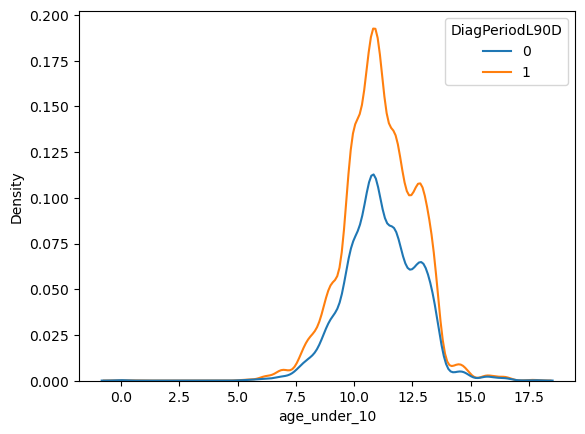

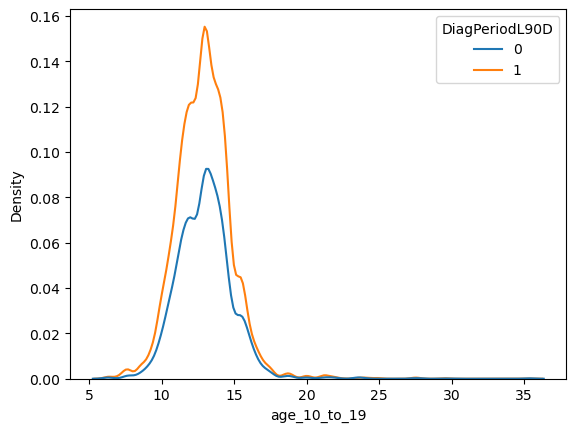

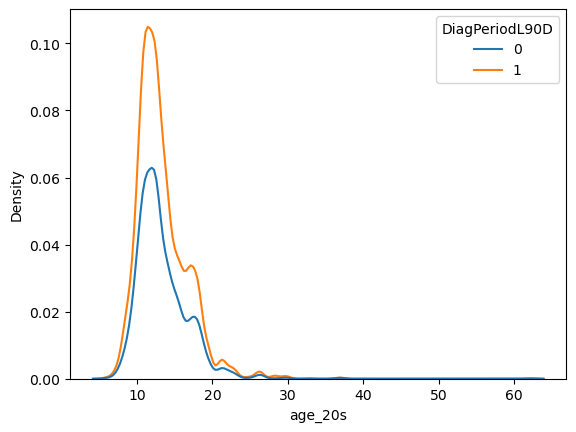

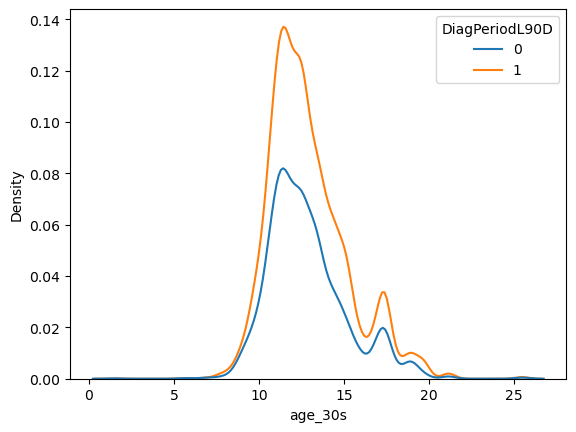

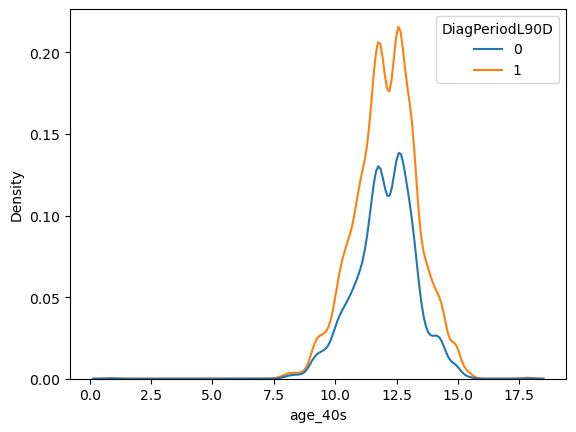

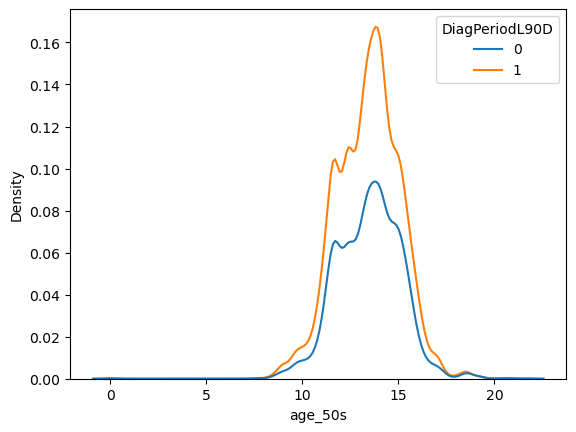

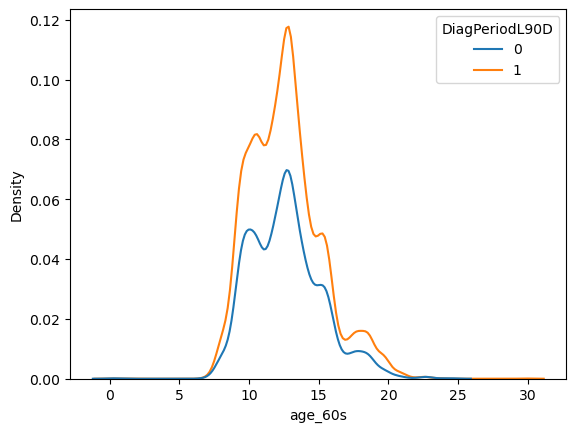

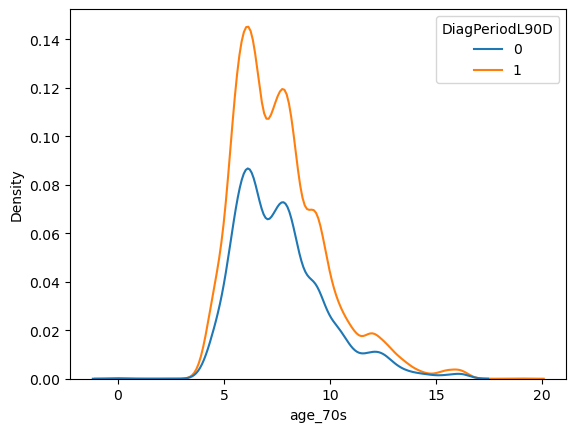

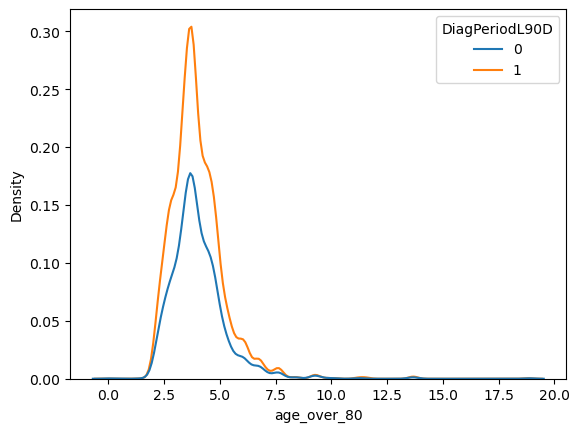

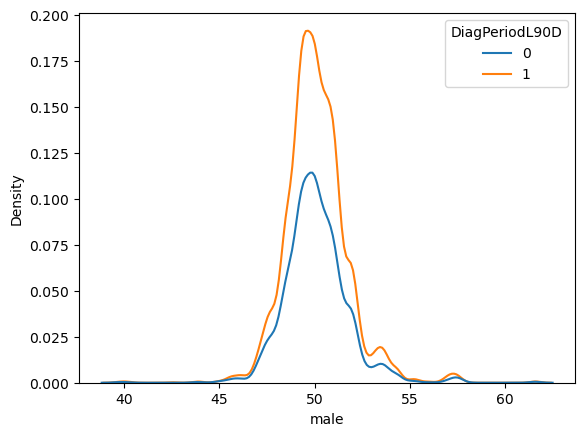

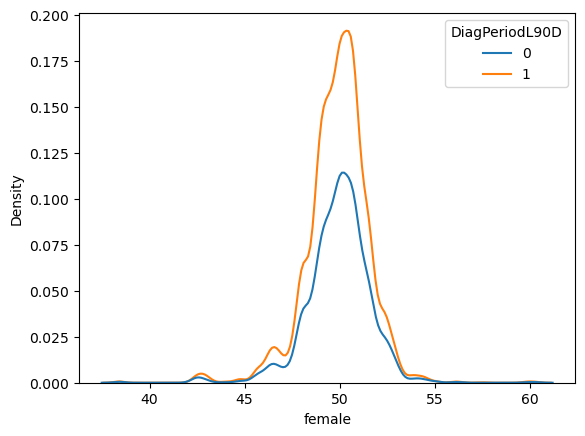

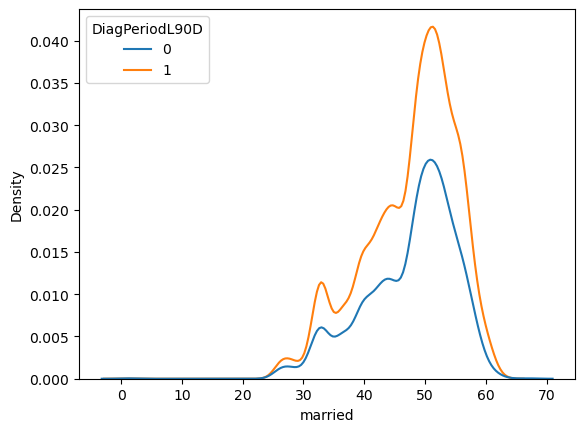

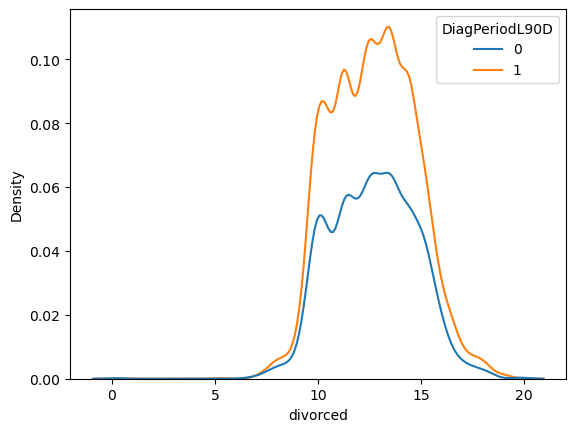

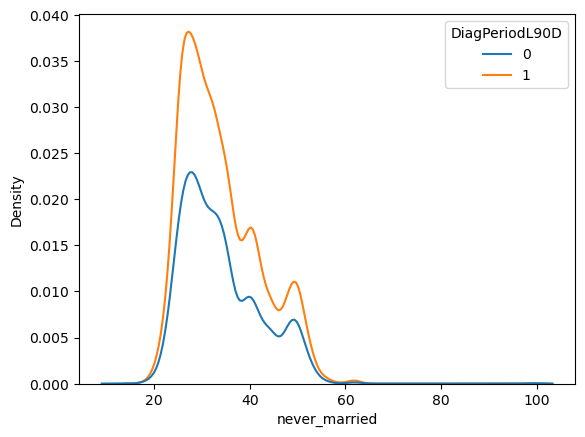

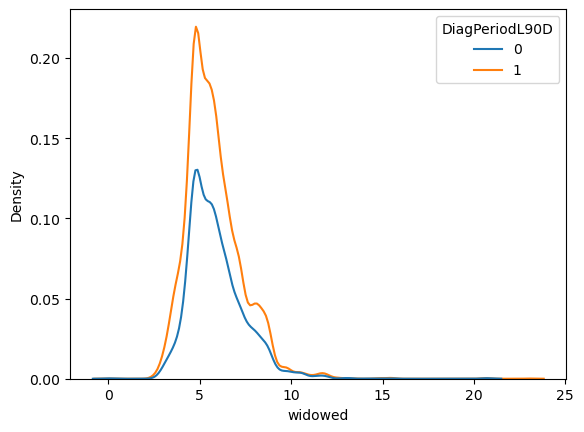

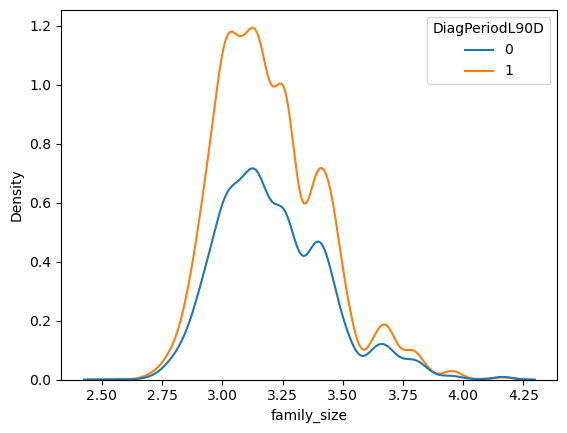

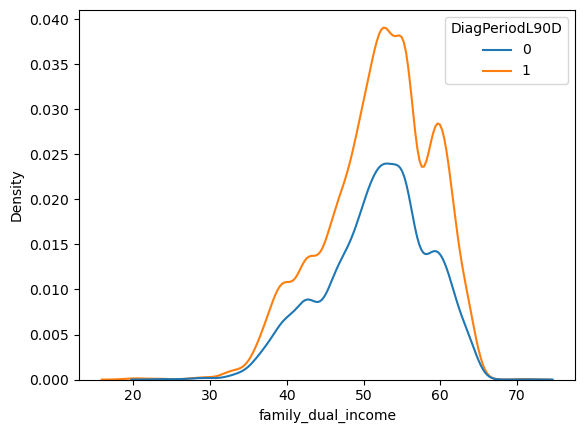

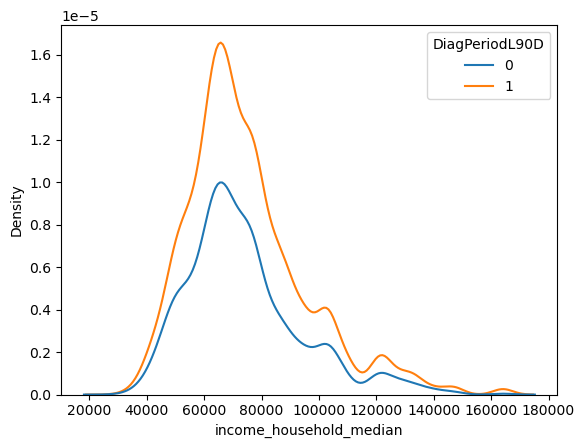

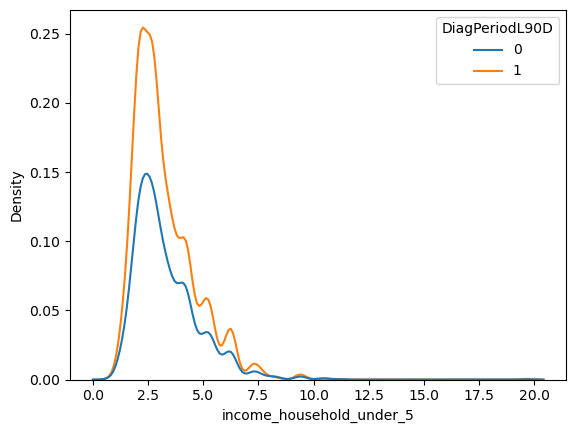

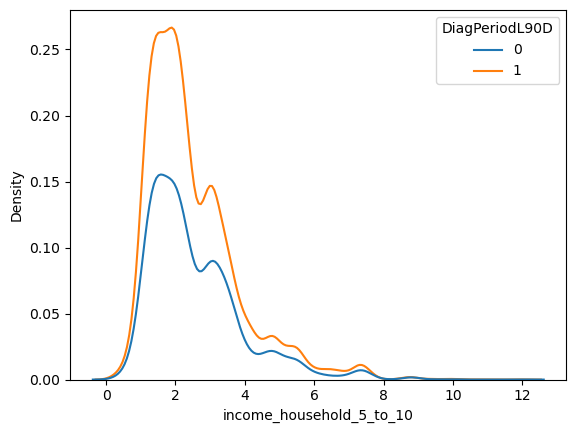

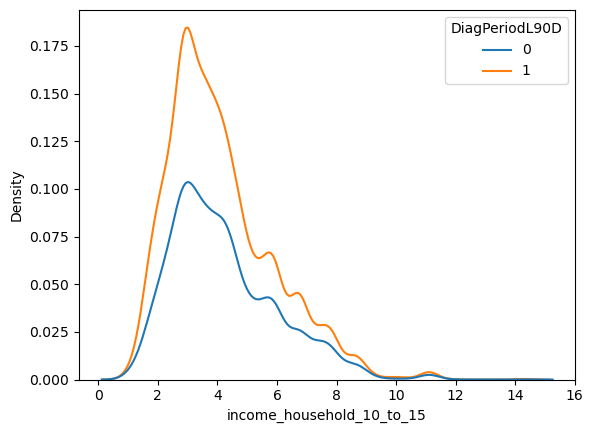

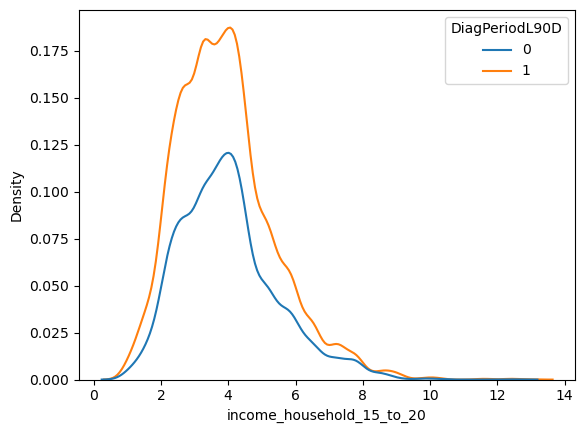

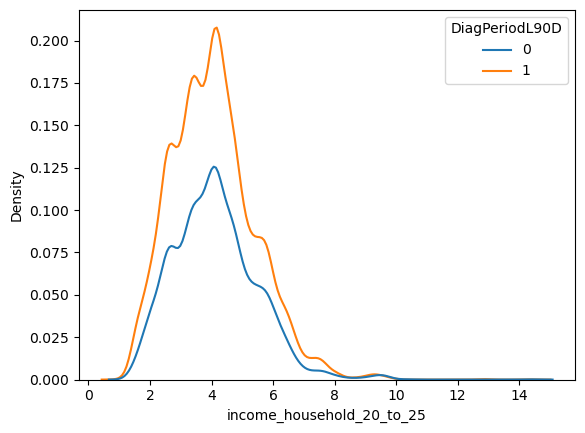

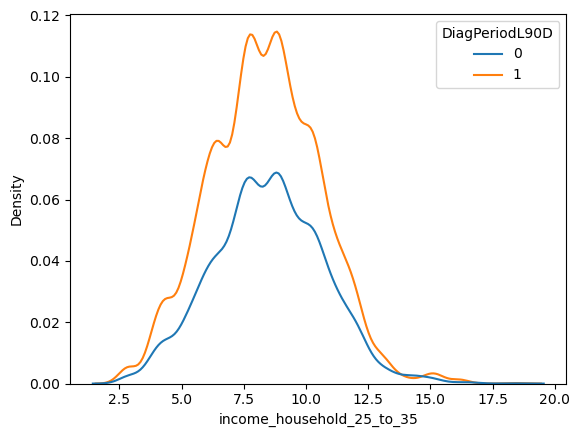

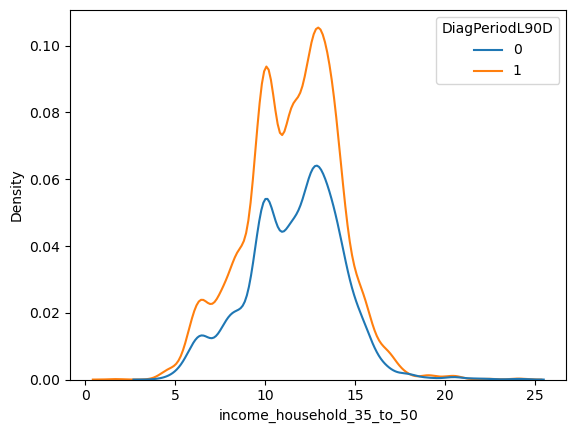

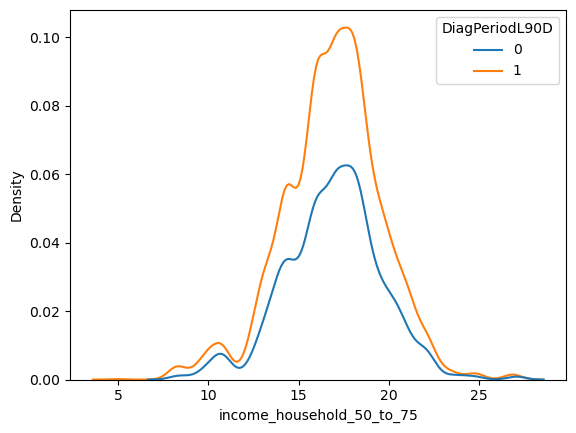

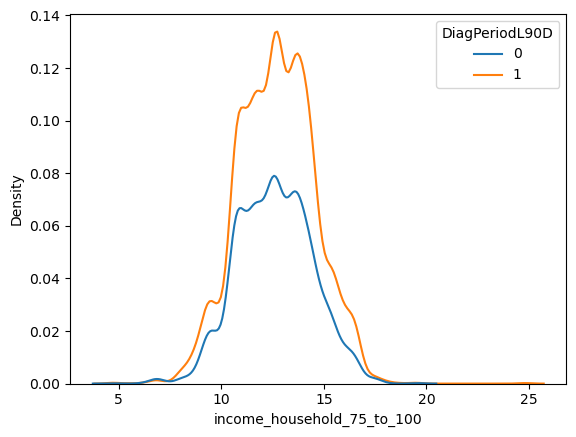

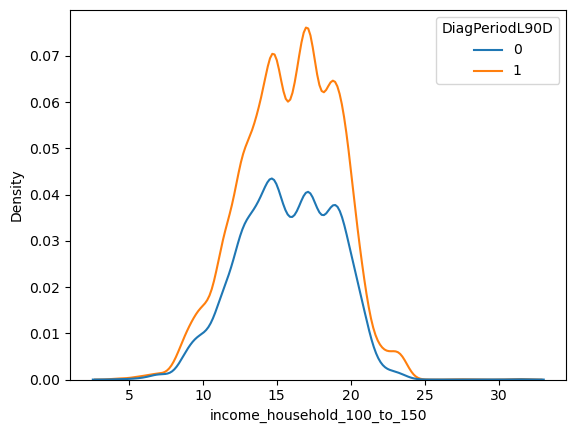

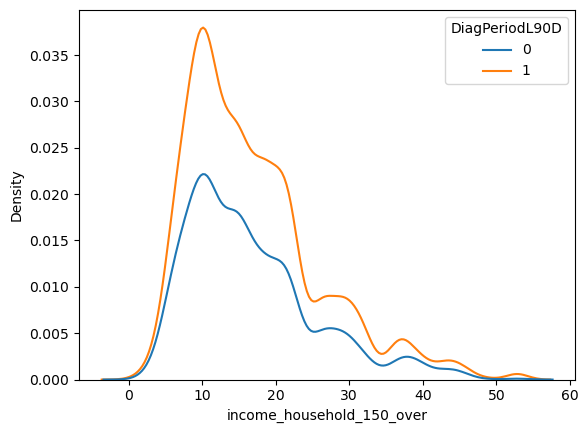

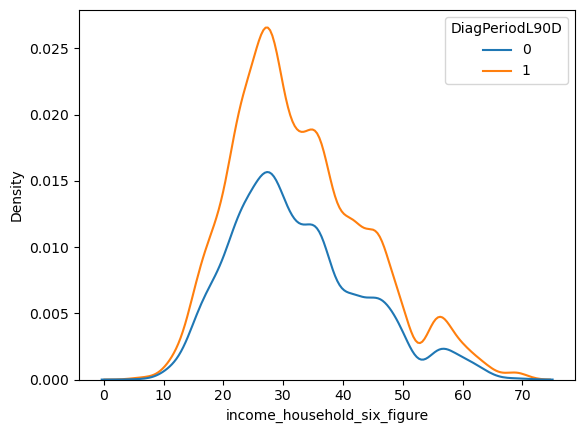

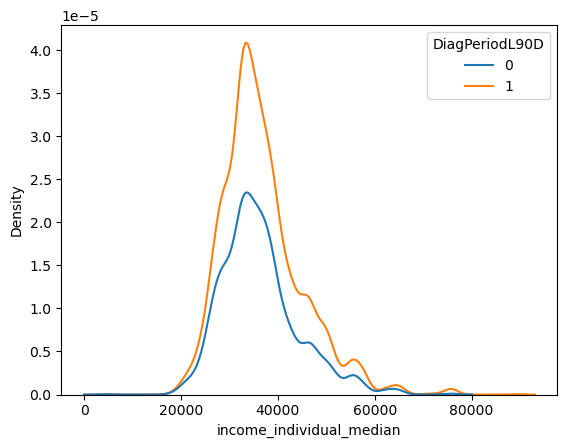

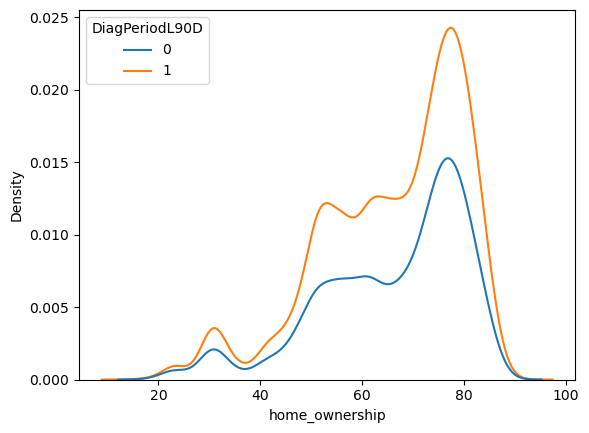

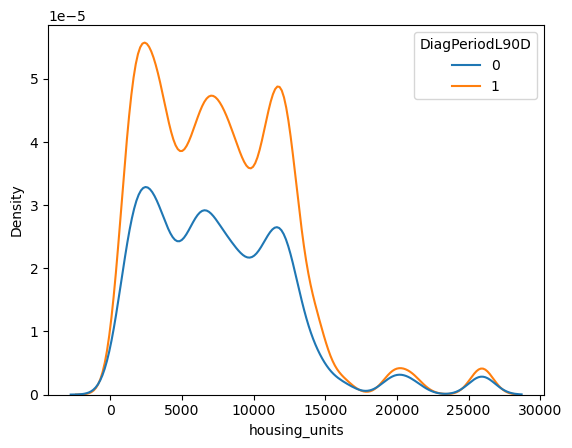

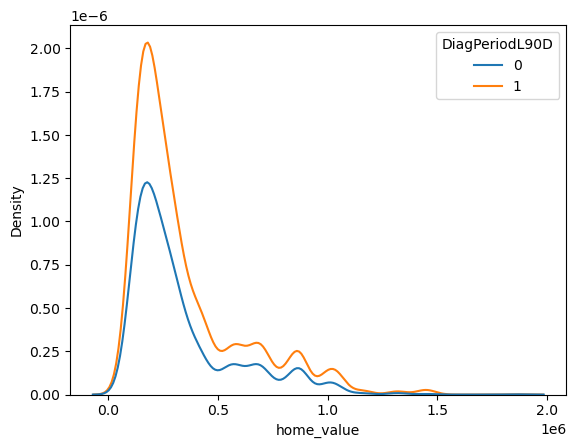

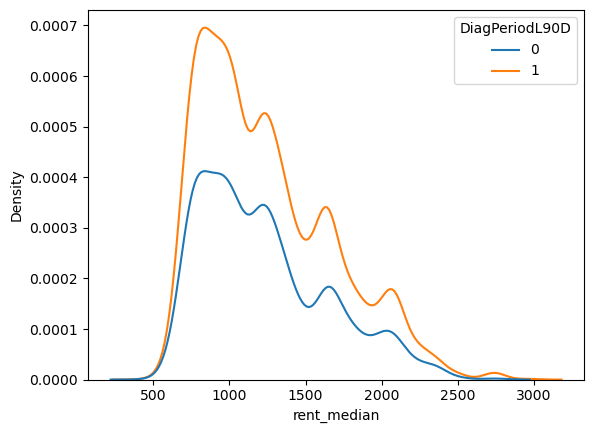

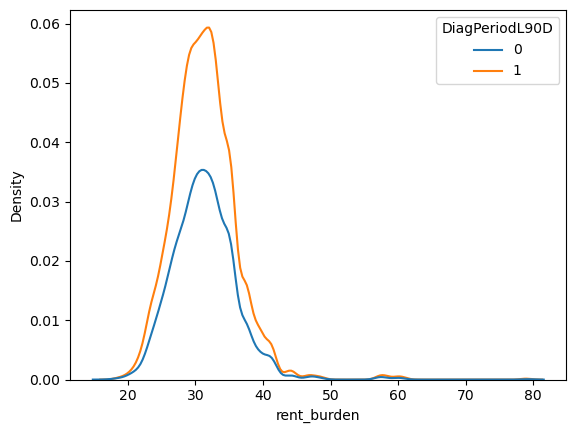

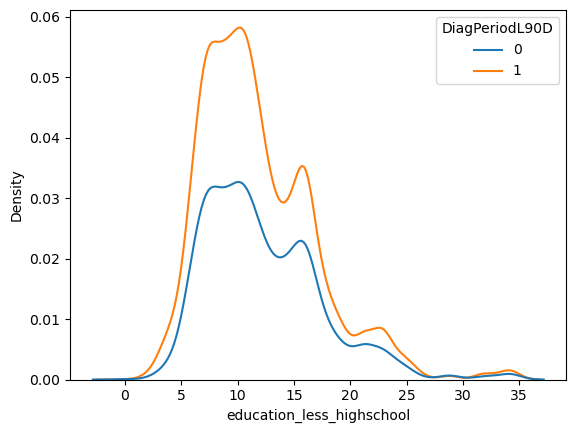

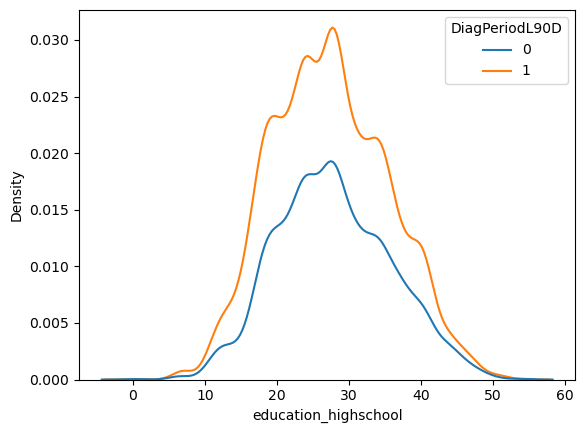

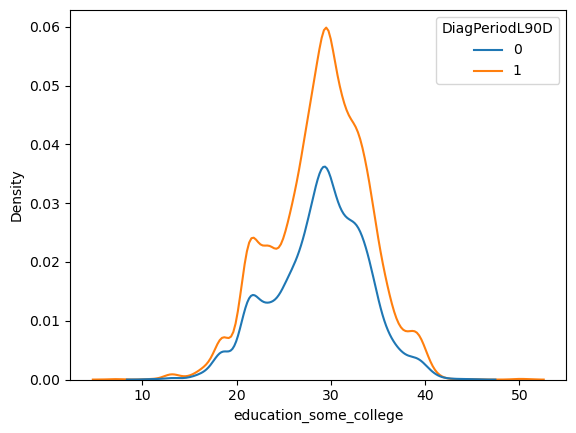

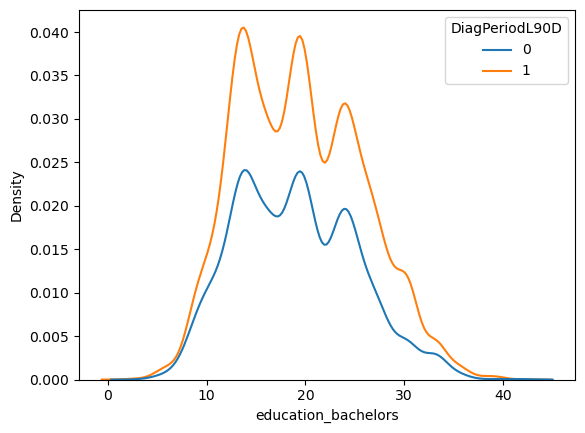

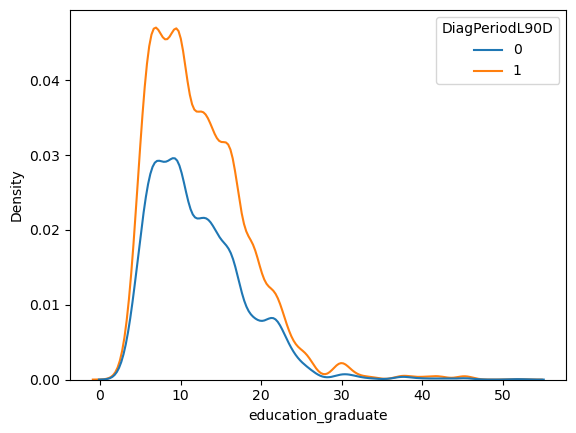

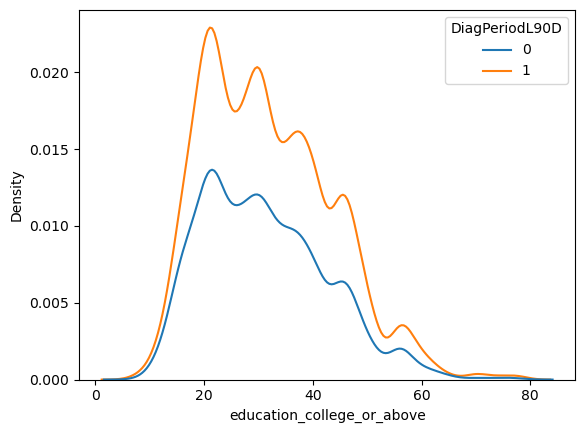

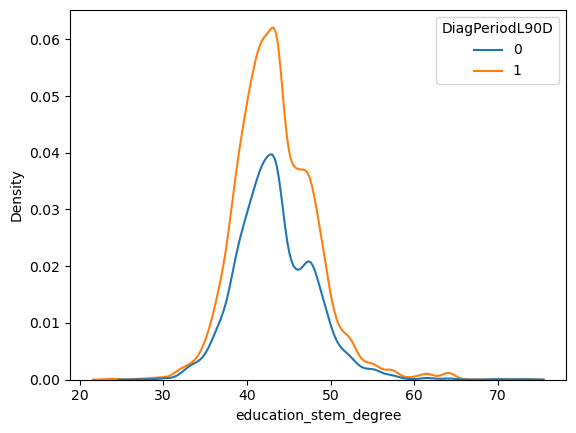

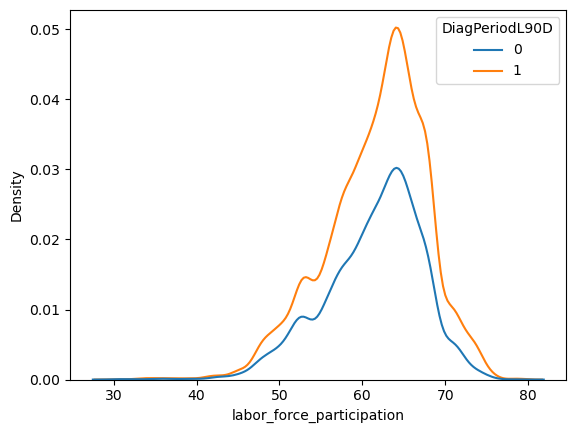

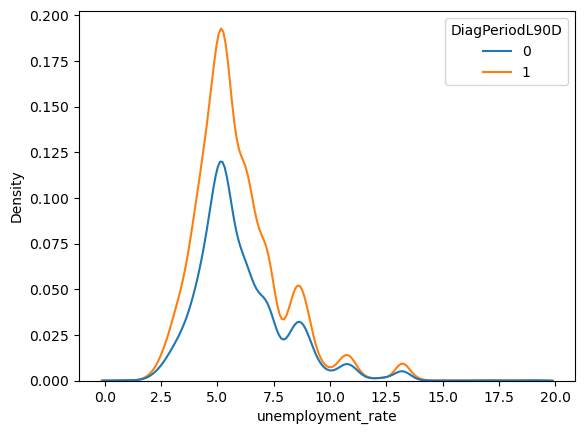

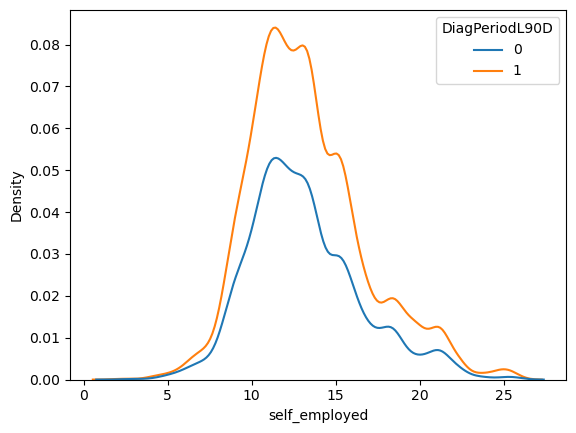

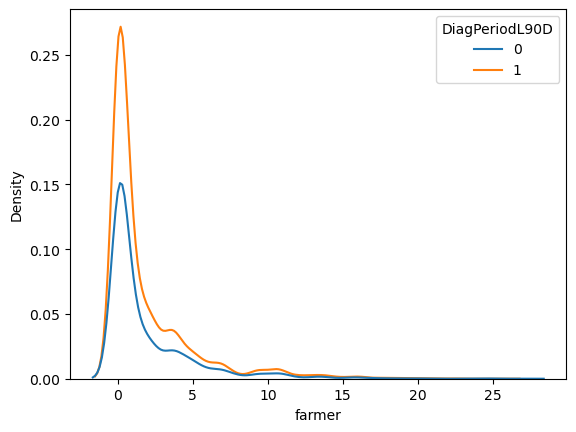

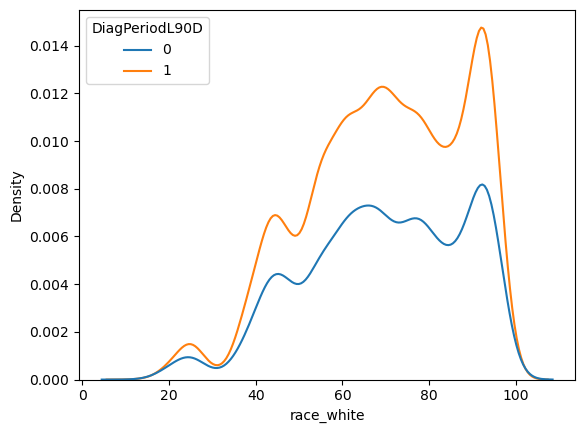

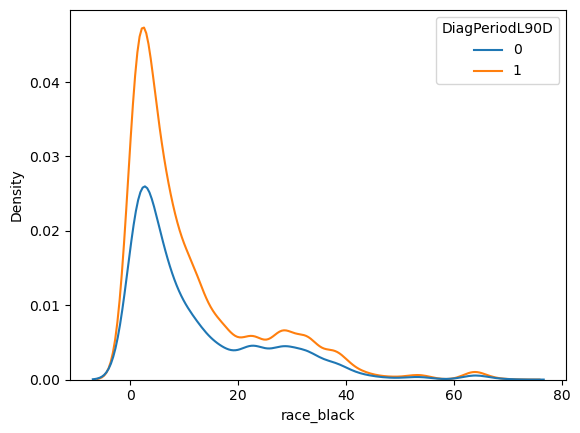

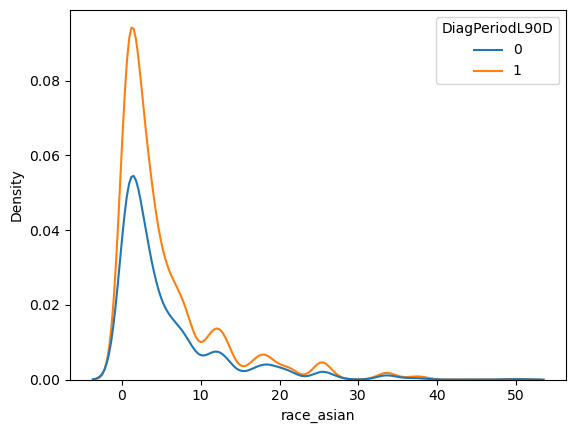

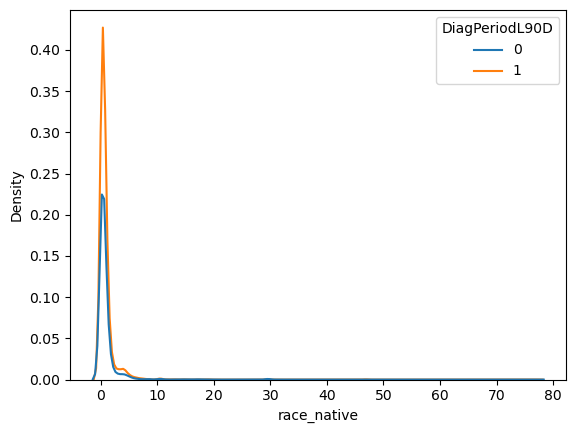

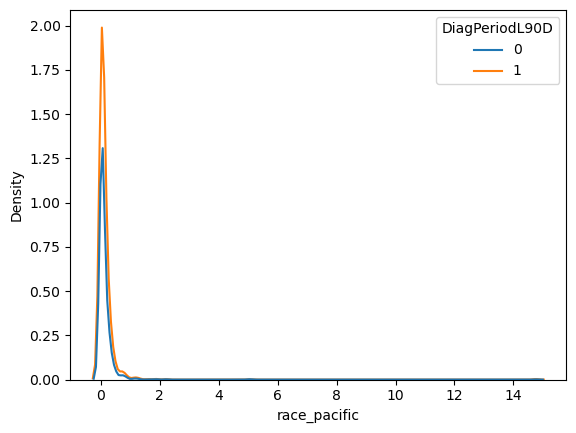

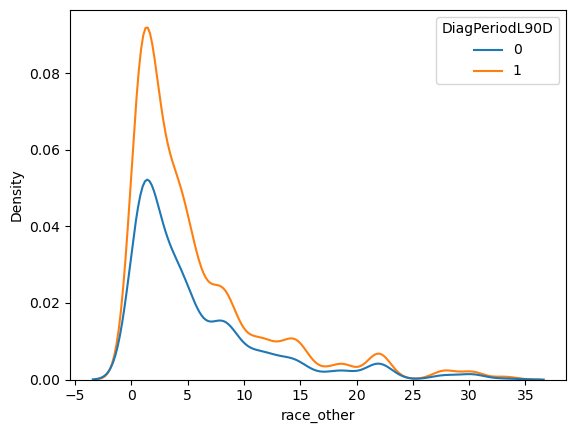

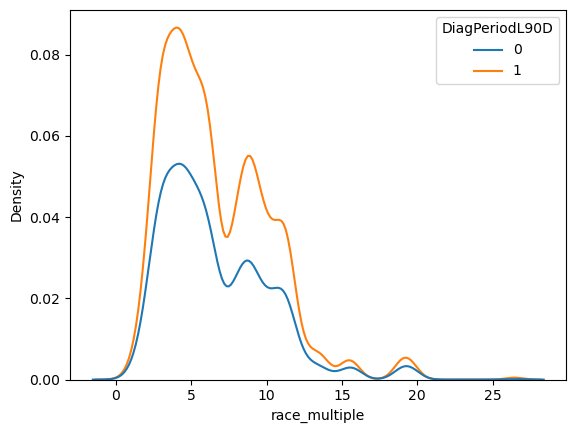

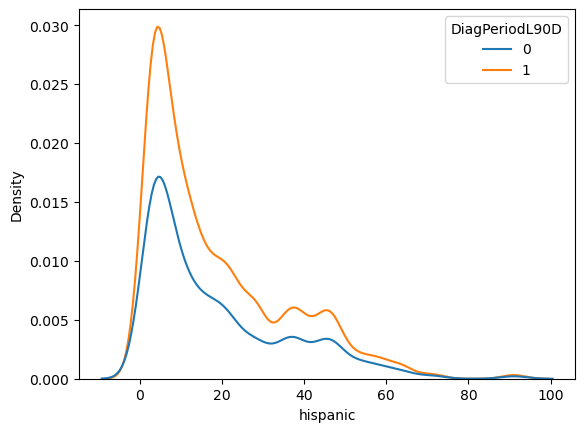

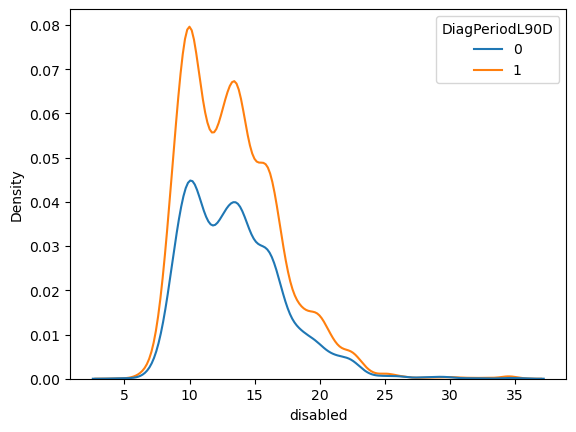

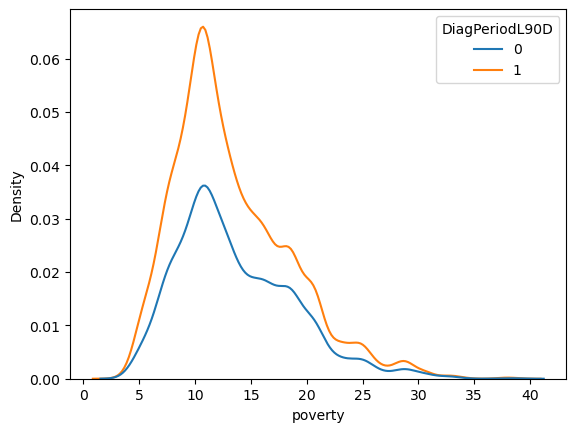

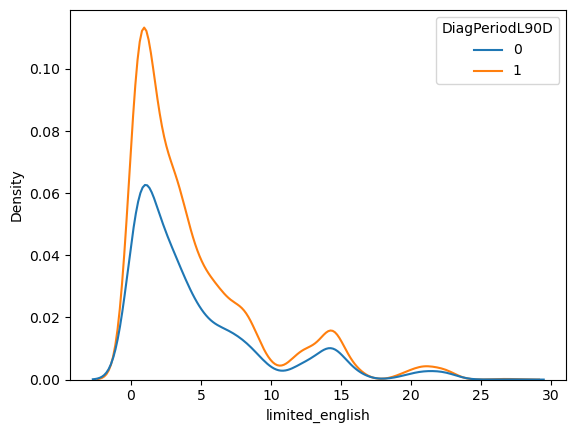

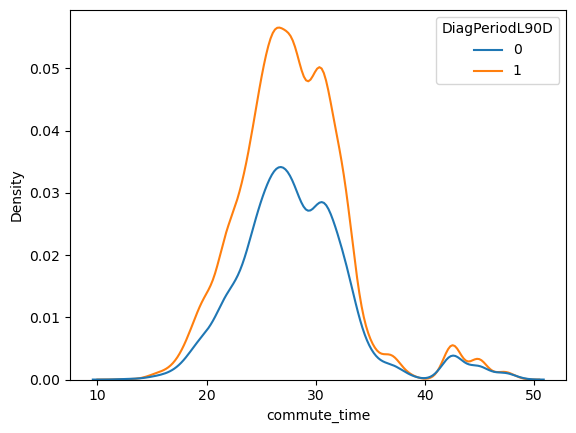

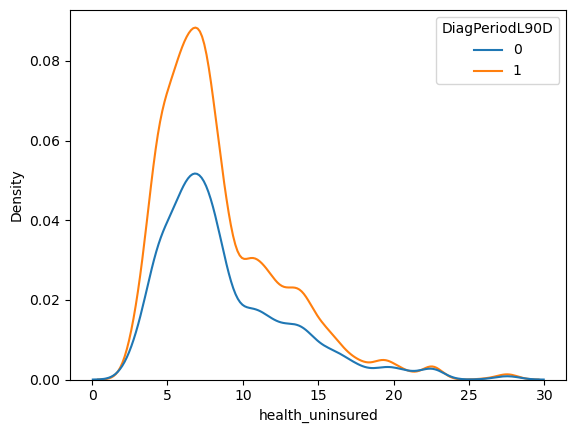

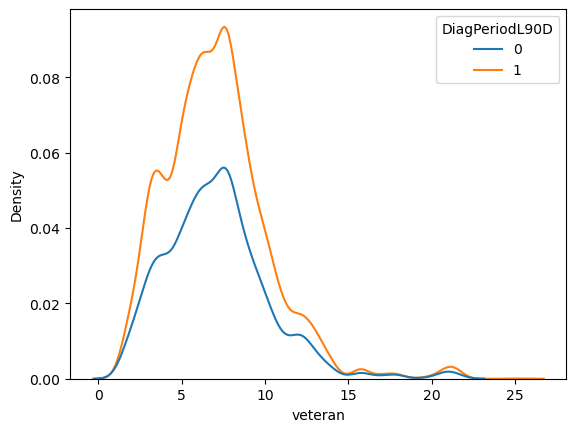

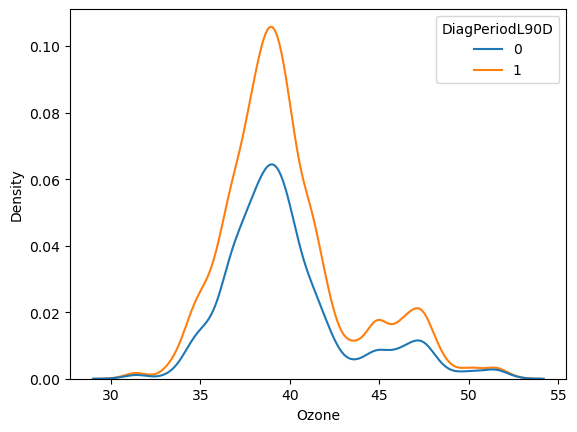

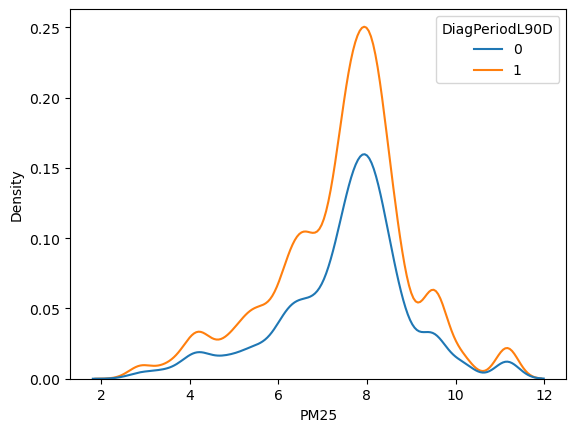

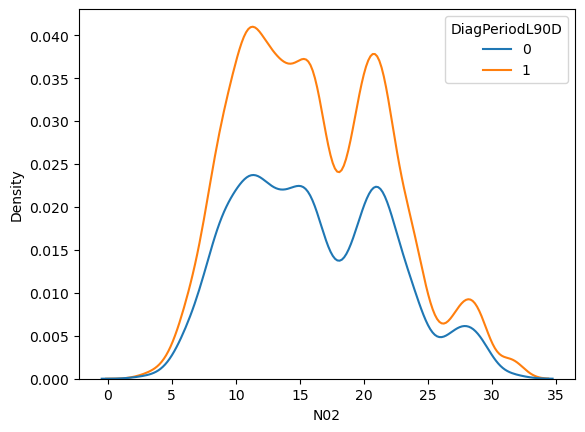

/var/folders/b1/zqzn387j6zd37gnn4xj6ym200000gn/T/ipykernel_55471/3934361367.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = data, x = i, hue = 'DiagPeriodL90D')


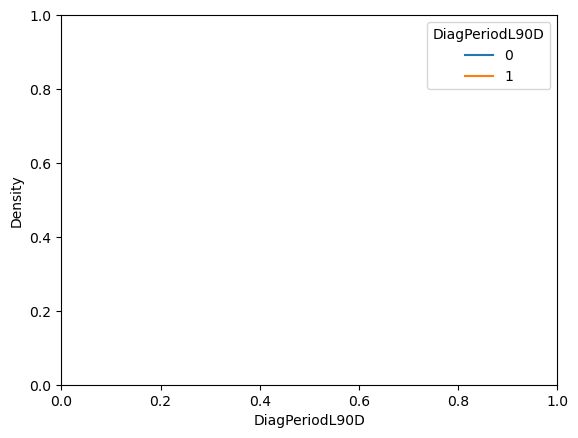

In [16]:
# Plot the KDE plot for all numeric variables
# Compare distributions between timely and untimely diagnosis groups

for i in num_cols:
    sns.kdeplot(data = data, x = i, hue = 'DiagPeriodL90D')
    plt.show()

Next, we examined the correlation between numeric variables to see if there was any unexpected positive or negative correlation relationships between variables. There was not.

In [17]:
# Look at highly correlated variables (threshold = 0.5)
# There are too many variables for a correlogram that will be easy to read

corr_df = data.corr(numeric_only = True)

for col in num_cols:
    if len(corr_df[col][corr_df[col] > 0.5]) > 1:
        print(col)
        print(corr_df[col][corr_df[col] > 0.5][corr_df[col] < 1])
        print()

population
density                0.730978
age_30s                0.636995
never_married          0.584668
housing_units          0.982847
home_value             0.559459
rent_median            0.631697
education_bachelors    0.514476
self_employed          0.520301
race_asian             0.592021
race_other             0.619619
hispanic               0.531255
limited_english        0.671453
N02                    0.672527
Name: population, dtype: float64

density
population         0.730978
age_30s            0.522595
never_married      0.518041
housing_units      0.746206
limited_english    0.586164
commute_time       0.590180
N02                0.578692
Name: density, dtype: float64

age_median
age_50s           0.686473
age_60s           0.875184
age_70s           0.887043
age_over_80       0.689430
married           0.602609
widowed           0.597982
home_ownership    0.664444
race_white        0.576772
Name: age_median, dtype: float64

age_20s
age_30s          0.557110
never_mar

In [18]:
# Look at highly negative correlation
for col in num_cols:
    if len(corr_df[col][corr_df[col] < -0.5]) > 1:
        print(col)
        print(corr_df[col][corr_df[col] < -0.5][corr_df[col] > -1])
        print()

population
age_median             -0.550534
age_60s                -0.650400
age_70s                -0.540140
home_ownership         -0.722400
education_highschool   -0.609417
farmer                 -0.532152
race_white             -0.724045
disabled               -0.533190
veteran                -0.500773
Name: population, dtype: float64

density
home_ownership           -0.693874
education_some_college   -0.505960
race_white               -0.560376
Name: density, dtype: float64

age_median
population      -0.550534
age_under_10    -0.530657
age_20s         -0.784668
age_30s         -0.678690
never_married   -0.734673
housing_units   -0.557695
Name: age_median, dtype: float64

age_20s
age_median       -0.784668
age_50s          -0.724620
age_60s          -0.715990
age_70s          -0.652237
married          -0.734612
widowed          -0.501848
home_ownership   -0.699405
race_white       -0.531631
Name: age_20s, dtype: float64

age_30s
age_median             -0.678690
age_60s          

## Categorical Variables

In [152]:
def get_perc_plot(df, num_cats, group_var, title):
    '''Reformat data from groupby aggregation for categorical bar plot'''

    # Vertical stack
    df = pd.concat([df['DiagPeriodL90D'][0],
                    df['DiagPeriodL90D'][1]],
                    axis = 0)
    
    # Cast to dataframe
    df = pd.DataFrame(df)
    
    cat_code = [0 for i in range(num_cats)]
    
    for i in range(num_cats):
        cat_code.append(1)
        
    
    df['diag_group'] = cat_code
    df = df.reset_index()
    
    df = df.rename(columns = {'DiagPeriodL90D': 'percent', 'diag_group': 'DiagPeriodL90D'})

    sns.catplot(data = df,
               x = group_var,
               y = 'percent',
               hue = 'DiagPeriodL90D',
               kind = 'bar').set(title = title)

In [19]:
categ_cols = [col for col in data if data[col].dtype == "object"]
categ_cols

['patient_race',
 'payer_type',
 'patient_state',
 'breast_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'metastatic_cancer_diagnosis_code',
 'Region',
 'Division']

Examining patient race, there is not a big difference in proportions for each racial group in the untimely and timely diagnosis groups. Generally, there was a smaller proportion for each group in the untimely diagnosis group, except for black and unknown race patients. 8.42% of patients with an untimely diagnosis were black, in comparison to 8.04% of patients in the timely diagnosis group. Additionally, 52% of patients were unknown race in the untimely diagnosis group in comparison to 47.95%. This indicated that race may play a role in health care inequities, but possibly not for every racial group.

In [84]:
# Examine by proportion in untimely vs timely groups
race_perc = data.groupby(by = ['DiagPeriodL90D', 
                   'patient_race']).agg({'DiagPeriodL90D':'count'}).groupby(level=0, 
                                                                            group_keys = False).apply(lambda x:100 * x / float(x.sum()))

race_perc

DiagPeriodL90D
DiagPeriodL90D patient_race                
0              Asian               2.785803
               Black               8.419315
               Hispanic            6.293851
               Other               5.262072
               Unknown            52.001651
               White              25.237309
1              Asian               2.853598
               Black               8.039702
               Hispanic            6.501241
               Other               5.310174
               Unknown            47.952854
               White              29.342432

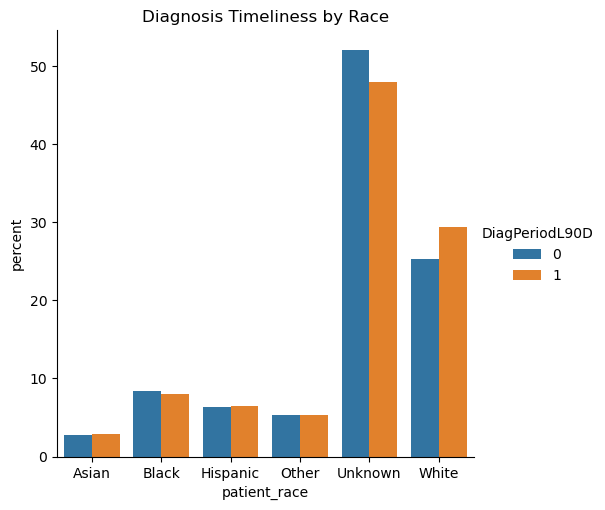

In [154]:
get_perc_plot(race_perc, 6, 'patient_race', title ='Diagnosis Timeliness by Race')

In [21]:
# Examine counts
data.groupby(by = ['DiagPeriodL90D', 'patient_race']).size()

DiagPeriodL90D  patient_race
0               Asian            135
                Black            408
                Hispanic         305
                Other            255
                Unknown         2520
                White           1223
1               Asian            230
                Black            648
                Hispanic         524
                Other            428
                Unknown         3865
                White           2365
dtype: int64

We also examined payer type and its relationship to diagnosis timeliness. We found that there was a higher proportion of Medicare Advantage, Medicaid, and unknown payer type patients in the timely group than in the untimely group. Commercial insurance patients made up a greater proportion of the untimely diagnosis patients.

In [129]:
# Examine by proportion in untimely vs timely groups
payer_perc = data.groupby(by = ['DiagPeriodL90D', 
                   'payer_type']).agg({'DiagPeriodL90D':'count'}).groupby(level=0, 
                        group_keys = False).apply(lambda x:100 * x / float(x.sum()))

payer_perc

DiagPeriodL90D
DiagPeriodL90D payer_type                        
0              COMMERCIAL               49.938093
               MEDICAID                 20.656211
               MEDICARE ADVANTAGE       18.468840
               Unknown                  10.936855
1              COMMERCIAL               44.813896
               MEDICAID                 19.454094
               MEDICARE ADVANTAGE       19.937965
               Unknown                  15.794045

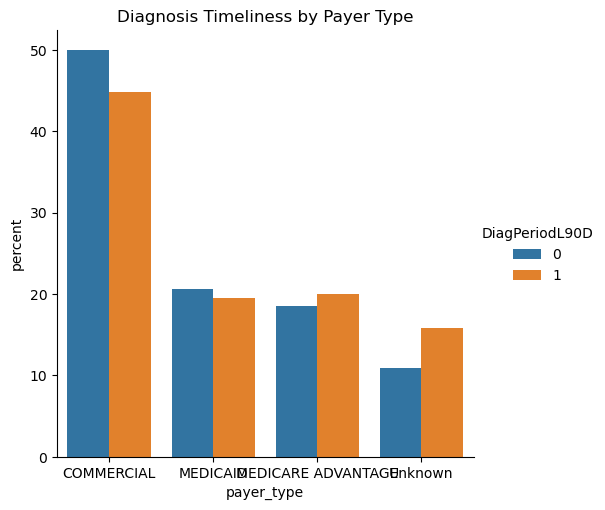

In [158]:
get_perc_plot(payer_perc, 4, 'payer_type', title ='Diagnosis Timeliness by Payer Type')

In [24]:
# Get the counts of patient payer type by diagnosis code
data.groupby(by = ['DiagPeriodL90D', 'payer_type']).size()

DiagPeriodL90D  payer_type        
0               COMMERCIAL            2420
                MEDICAID              1001
                MEDICARE ADVANTAGE     895
                Unknown                530
1               COMMERCIAL            3612
                MEDICAID              1568
                MEDICARE ADVANTAGE    1607
                Unknown               1273
dtype: int64

Next, we examined region and division or geographic location of the patient.

On the regional level (the broader geographic category), the South and Northeast patients were proportionally higher in the untimely diagnosis group in comparison to the timely diagnosis group. The difference was biggest for the Southern patients, where the untimely proportion was 32% in comparison to 29.5% of the timely group.

In [159]:
# Examine by proportion in untimely vs timely groups
region_perc = data.groupby(by = ['DiagPeriodL90D', 
                   'Region']).agg({'DiagPeriodL90D':'count'}).groupby(level=0, 
                    group_keys = False).apply(lambda x:100 * x / float(x.sum()))

region_perc


DiagPeriodL90D
DiagPeriodL90D Region                   
0              Midwest         27.816901
               Northeast       13.173157
               South           32.187241
               West            26.822701
1              Midwest         28.744082
               Northeast       11.387989
               South           29.466733
               West            30.401196

In [27]:
# Get the counts of patient region by diagnosis code
data.groupby(by = ['DiagPeriodL90D', 'Region']).size()

DiagPeriodL90D  Region   
0               Midwest      1343
                Northeast     636
                South        1554
                West         1295
1               Midwest      2307
                Northeast     914
                South        2365
                West         2440
dtype: int64

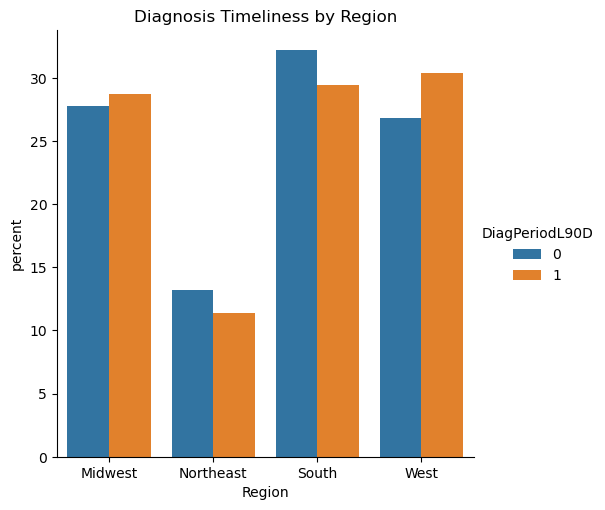

In [160]:
get_perc_plot(region_perc, 4, 'Region', title ='Diagnosis Timeliness by Region')

Looking at the more specific geographic location, division, the differences were not as large. The Middle Atlantic and South Atlantic had higher proportions in the untimely group in comparison to the timely group.

In [161]:
# Examine by proportion in untimely vs timely groups
division_perc = data.groupby(by = ['DiagPeriodL90D', 
                   'Division']).agg({'DiagPeriodL90D':'count'}).groupby(level=0, 
                    group_keys = False).apply(lambda x:100 * x / float(x.sum()))

division_perc


DiagPeriodL90D
DiagPeriodL90D Division                          
0              East North Central       22.763049
               East South Central        4.370340
               Middle Atlantic          13.131732
               Mountain                  6.524441
               New England               0.041425
               Pacific                  20.298260
               South Atlantic           16.114333
               West North Central        5.053853
               West South Central       11.702568
1              East North Central       22.726140
               East South Central        3.563419
               Middle Atlantic          11.350611
               Mountain                  8.298031
               New England               0.037379
               Pacific                  22.103165
               South Atlantic           14.876651
               West North Central        6.017942
               West South Central       11.026663

In [30]:
# Get the counts of patient payer type by diagnosis code
data.groupby(by = ['DiagPeriodL90D', 'Division']).size()

DiagPeriodL90D  Division          
0               East North Central    1099
                East South Central     211
                Middle Atlantic        634
                Mountain               315
                New England              2
                Pacific                980
                South Atlantic         778
                West North Central     244
                West South Central     565
1               East North Central    1824
                East South Central     286
                Middle Atlantic        911
                Mountain               666
                New England              3
                Pacific               1774
                South Atlantic        1194
                West North Central     483
                West South Central     885
dtype: int64

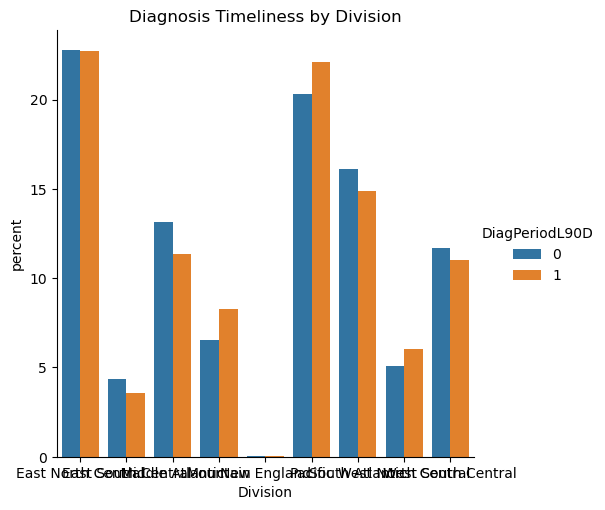

In [165]:
get_perc_plot(division_perc, 9, 'Division', title ='Diagnosis Timeliness by Division')

Because the previous factors did not have very large differences in proportions between timely and untimely diagnosis groups, we considered whether the type of breast cancer affected the outcomes for patients. This information was provided in the dataset as the breast cancer diagnosis code and description. While it could be argued that we may not have breast cancer diagnosis information for a completely new and undiagnosed patient, it may still be informative if the type of breast cancer affects the speed of diagnosis.

Examining the two variables, the code and the description, as is, we can see there is a wide range of frequency, with some codes and descriptions being very commonly used, and some very uncommonly used. Looking more into the codes, it appeared that the very uncommon codes were very specific about the tumor location, while more common codes were less specific about tumor location.

In [32]:
data['breast_cancer_diagnosis_code'].value_counts()

1749      1982
C50911    1797
C50912    1712
C50919    1467
C50411     978
C50412     877
C50811     491
C50812     419
1744       389
1748       307
C50212     293
C50211     276
C50511     213
C50112     209
C50111     208
C50512     176
C50312     159
C50311     138
C50011     108
C50012     105
1742        98
1741        88
1745        71
C50819      54
C50419      48
C5091       37
1743        34
C50612      29
C50611      25
C50319      16
C50019      13
1746        12
C50219      11
C50119      11
C5041        9
19881        9
C5081        8
C50519       8
C5021        3
C509         3
C50929       3
C50619       3
C5011        2
C50021       1
C5031        1
C5051        1
C50          1
1759         1
C5001        1
C50421       1
Name: breast_cancer_diagnosis_code, dtype: int64

In [33]:
data['breast_cancer_diagnosis_desc'].value_counts()

Malignant neoplasm of breast (female), unspecified                  1982
Malignant neoplasm of unsp site of right female breast              1797
Malignant neoplasm of unspecified site of left female breast        1712
Malignant neoplasm of unsp site of unspecified female breast        1467
Malig neoplm of upper-outer quadrant of right female breast          978
Malig neoplasm of upper-outer quadrant of left female breast         877
Malignant neoplasm of ovrlp sites of right female breast             491
Malignant neoplasm of ovrlp sites of left female breast              419
Malignant neoplasm of upper-outer quadrant of female breast          389
Malignant neoplasm of other specified sites of female breast         307
Malig neoplasm of upper-inner quadrant of left female breast         293
Malig neoplm of upper-inner quadrant of right female breast          276
Malig neoplm of lower-outer quadrant of right female breast          213
Malignant neoplasm of central portion of left femal

We then processed the data further to ascertain if tumor location or frequency of the code affected the diagnosis timeliness. 

In [34]:
# Create a dictionary mapping diagnosis code to the frequency
code_counts = Counter(data['breast_cancer_diagnosis_code'])

In [35]:
# Loop through the codes in the dataset to map the frequency then attach to the df
code_freq_list = [code_counts[i] for i in data['breast_cancer_diagnosis_code']]
data['code_counts'] = code_freq_list

# Create another variable classifying if the code is common or uncommon
data['common_code'] = np.where(data['code_counts']>=300, 'Common', 'Uncommon')

In [36]:
data['common_code'].value_counts()

Common      10419
Uncommon     2487
Name: common_code, dtype: int64

In [37]:
# Loop through the descriptions to get the tumor location
tumor_loc_list = []

for i in data['breast_cancer_diagnosis_desc']:
    if 'left' in i:
        tumor_loc_list.append('Left')
    elif 'right' in i:
         tumor_loc_list.append('Right')
    else:
        tumor_loc_list.append('Unspecified')
        
data['tumor_loc'] = tumor_loc_list

In [38]:
data['tumor_loc'].value_counts()

Unspecified    4691
Right          4236
Left           3979
Name: tumor_loc, dtype: int64

We found that there was some difference in proportions for using a common or uncommon breast cancer diagnosis code. Uncommon codes made up a higher proportion of the timely group in comparison to the untimely group, with a difference of about 6%.

In [166]:
# Examine by proportion in untimely vs timely groups
code_perc = data.groupby(by = ['DiagPeriodL90D', 
                   'common_code']).agg({'DiagPeriodL90D':'count'}).groupby(level=0, 
                    group_keys = False).apply(lambda x:100 * x / float(x.sum()))

code_perc


DiagPeriodL90D
DiagPeriodL90D common_code                
0              Common            84.110607
               Uncommon          15.889393
1              Common            78.697270
               Uncommon          21.302730

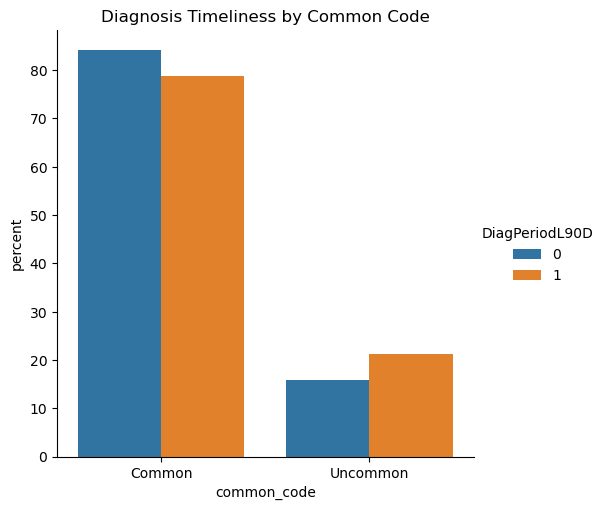

In [167]:
get_perc_plot(code_perc, 2, 'common_code', title ='Diagnosis Timeliness by Common Code')

We found an even greater difference in proportions by tumor location, with unspecified location cases making up the majority of the untimely diagnosis group, 63.74%, in comparison to 19.88% of the timely diagnosis group. 

We could interpret these results as either that the specific location of the tumor matters, such as maybe a right breast tumor is faster to diagnose, or that not specifying the location affects the diagnosis speed. 

It is possible that different kinds of patients encounter different doctors or different healthcare providers that result in a more specific or less specific diagnosis code, which corresponds with diagnosis speed.

In [168]:
# Examine by proportion in untimely vs timely groups
tumor_perc = data.groupby(by = ['DiagPeriodL90D', 
                   'tumor_loc']).agg({'DiagPeriodL90D':'count'}).groupby(level=0, 
                   group_keys = False).apply(lambda x:100 * x / float(x.sum()))

tumor_perc


DiagPeriodL90D
DiagPeriodL90D tumor_loc                  
0              Left              17.767231
               Right             18.489476
               Unspecified       63.743293
1              Left              38.684864
               Right             41.439206
               Unspecified       19.875931

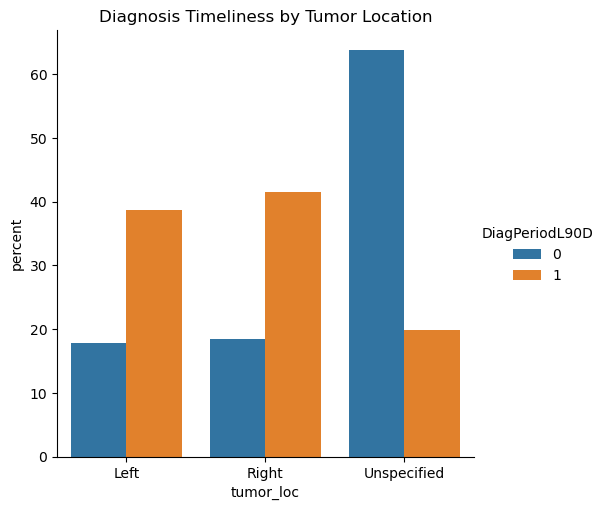

In [170]:
get_perc_plot(tumor_perc, 3, 'tumor_loc', title ='Diagnosis Timeliness by Tumor Location')

In [41]:
# Examine by tumor location and race
data.groupby(by = ['tumor_loc', 
                   'patient_race']).agg({'tumor_loc':'count'}).groupby(level=0, 
                                                                            group_keys = False).apply(lambda x:100 * x / float(x.sum()))


tumor_loc
tumor_loc   patient_race           
Left        Asian          3.015833
            Black          8.946972
            Hispanic       6.132194
            Other          5.001257
            Unknown       46.644886
            White         30.258859
Right       Asian          2.360718
            Black          8.640227
            Hispanic       6.704438
            Other          5.476865
            Unknown       48.961284
            White         27.856468
Unspecified Asian          3.091025
            Black          7.120017
            Hispanic       6.416542
            Other          5.371989
            Unknown       52.334257
            White         25.666169